In [2]:
# utilization
import os
from tqdm import tqdm
from glob import glob
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data manipulation and visualization tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# cross-validaion and evaluation tools
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, train_test_split

# model development and data preparation
import torch
import torchvision
from create_dataset import *

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image
from torchvision import transforms as t


# GradCAM implementations and some utility tools
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, LayerCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

torch.backends.cudnn.benchmark = True

# Prepare the dataset

In [3]:
# image data path
DATAPATH = r'american_bankruptcy.csv'

logging.basicConfig(level=logging.INFO)
df_raw = load_data(DATAPATH)
dataset = create_dataset(df_raw)

INFO:root:Preprocessing data...
100%|██████████| 8971/8971 [01:27<00:00, 102.20it/s]
/Users/michaelyuan/Desktop/Capstone/Interpretation-DNN/create_dataset.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios_df[column] = df["X{}".format(i+1)] / df["X{}".format(j+1)]
/Users/michaelyuan/Desktop/Capstone/Interpretation-DNN/create_dataset.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios_df[column] = df["X{}".format(i+1)] / df["X{}".format(j+1)]
/Users/michaelyuan/Desktop/Capstone/Interpretation-DNN/create_dataset.p

In [4]:
ratios_df = ratios_dataframe(df_raw)
# ratios_df['test'] = df_raw["X9"] / df_raw["X16"]
# print(ratios_df['test'].describe())
for colunm in ratios_df.columns:
    if ratios_df[colunm].isnull().any():
        print(ratios_df[colunm].isnull())
# print(ratios_df['X9/X16'].head())

/Users/michaelyuan/Desktop/Capstone/Interpretation-DNN/create_dataset.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios_df[column] = df["X{}".format(i+1)] / df["X{}".format(j+1)]
/Users/michaelyuan/Desktop/Capstone/Interpretation-DNN/create_dataset.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios_df[column] = df["X{}".format(i+1)] / df["X{}".format(j+1)]
/Users/michaelyuan/Desktop/Capstone/Interpretation-DNN/create_dataset.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [5]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    """ Shows random N samples from the dataset """
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # then it is in the form (x, y)
            sample, label = sample
            label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        sample = sample.permute(1, 2, 0).reshape(64, 64)
        image = plt.cm.gray(sample)

        axs[0, i].imshow(sample, cmap='gray')
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

In [6]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

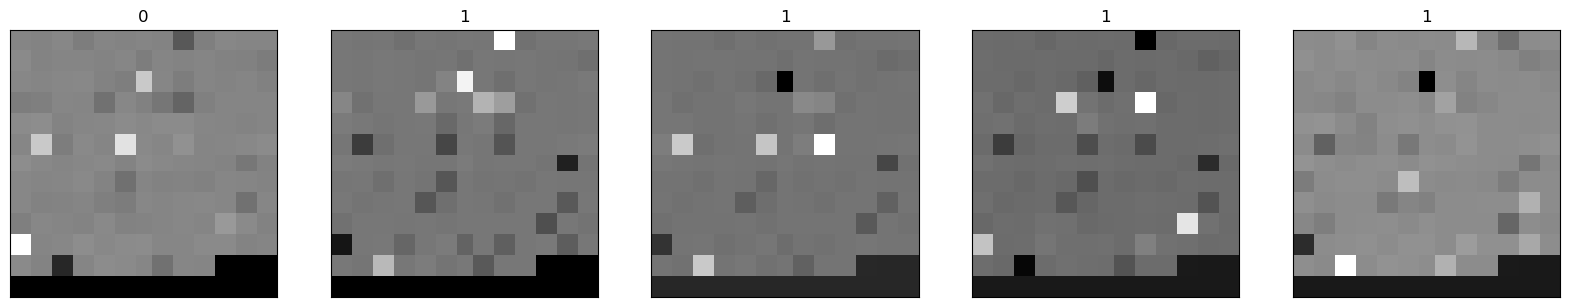

In [7]:
show(train_loader.dataset)
# print(df_raw.head())
# print(dataset[:3])

# Grad-CAM

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(SimpleCNN, self).__init__()

        # Convolutional layer 1
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Fully connected layer 1
        self.fc1 = nn.Linear(64 * 16 * 16, 64)  # input image size is 64x64
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
### This code is revised but originated from kaggle: https://www.kaggle.com/code/raqhea/visualizing-cnn-activations-gradcam-tutorial

def gradcam(model, gradcam_obj, layers, targets, dataset, N=5, use_cuda=False, show_labels=False, idx_to_label=None, **gradcam_params):
    random_indices = np.random.randint(0, len(dataset), N)
    samples = [dataset[idx][0].unsqueeze(0) for idx in random_indices]
    input_tensor = torch.cat(samples, dim=0)
    
    if show_labels:
        labels = [dataset[idx][1] for idx in random_indices]
        if idx_to_label:
            labels = [idx_to_label[label] for label in labels]
    
    for idx, layer in enumerate(layers):
        target_layers = [layer]
        
        # Construct the CAM object once, and then re-use it on many images.
        # since we will be using it for every single convolutional layer, I will redefine it every time
        cam = gradcam_obj(model=model, target_layers=target_layers, use_cuda=use_cuda)
        
        # You can also pass aug_smooth=True and eigen_smooth=True to apply smoothing.
        print(input_tensor.shape, target_layers)
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets, **gradcam_params)

        images = [input_tensor[idx].permute(1,2,0).numpy() for idx in range(N)]
        print(images[0].type)
        grayscaled_cam = [grayscale_cam[idx,:] for idx in range(N)]
        heatmaps_on_inputs = [show_cam_on_image(img, cam) for img, cam in zip(images, grayscaled_cam)]
        
        viz_img_list = [images, grayscaled_cam, heatmaps_on_inputs]
        subfig_titles = ["Input Images", "Grayscaled Heatmap", "Heatmaps on the Inputs"]
        
        fig = plt.figure(figsize=(20, 10))
        subfigs = fig.subfigures(nrows=3, ncols=1)

        fig.suptitle(f'GradCAM for layer: {idx+1}', fontsize=18, y=1.05)
        for subfig_idx, subfig in enumerate(subfigs):
            subfig.suptitle(subfig_titles[subfig_idx], y=1)
            
            viz_list = viz_img_list[subfig_idx]
            
            axs = subfig.subplots(nrows=1, ncols=N)
            for idx in range(N):
                axs[idx].imshow(viz_list[idx], cmap='gray')
                
                if show_labels:
                    axs[idx].set_title(labels[idx])
                
                axs[idx].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            
        plt.show()

        print('-'*150)
        print("\n\n")

In [10]:
# model = torch.jit.load('models/model_scripted.pt')
model = torch.load('models/model.pt')
model.eval()
cnn_layers = [model.conv1, model.conv2]

targets = [ClassifierOutputSoftmaxTarget(i) for i in range(2)]
val_dataset = test_data

In [11]:
gradcam(model, GradCAM, cnn_layers, targets, val_dataset, aug_smooth=False, eigen_smooth=False, use_cuda=False)

torch.Size([1, 1, 64, 64]) [Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
